# AI Generated Heatmaps 

Generating complex heatmaps with multiple sources are compute intensive algorithms. Often, one must iterate through every pixel in the space, and sum the computed rolled off intensities of every "source" in the space at each pixel location. Typical heatmap algorithms also have a fixed diffusion computation (such as inverse square law) and do not learn actual spatial relationships for intensity / distance. More importantly, there are no off-the-shelf algorithms for modeling diffusion patterns of different IEQ analytes in arbitrary interior spaces. We propose that a Neural Network can learn these patterns and then generate heatmaps from sparse inputs containing measured intensities at known spatial locations. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def get_sparse_matrix(m, n, s):
    """In our case, a sparse matrix is a matrix composed mostly of zeros
        with the source intensities representing the non-zero values
        m x n is the output matrix size
        s is a list of 'sources' [[intensity_0, x_0, y_0],[intensity_1, x_1, y_1],...]
    """
    matrix = np.zeros((m, n))
    for i in range(s.shape[0]):
        matrix[int(s[i][1])][int(s[i][2])] = s[i][0]

    return matrix

def intensity_from_source(target_x, target_y, source_intensity, source_x, source_y):
    """compute the inverse squared intensity"""
    distance = np.sqrt((source_x - target_x) ** 2 + (source_y - target_y) ** 2)
    if distance == 0:  # Prevent division by zero
        return source_intensity
    return source_intensity / (distance ** 2)

def intensity_matrix(m, n, sources):
    """build a heatmap of m x n size from a list of 'sources' """
    matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            for source in sources:
                source_intensity, source_x, source_y = source
                matrix[i][j] += intensity_from_source(i, j, source_intensity, source_x, source_y)
    return matrix


###### Some new stuff from Trevor
def log_scale_matrix(matrix, min_element_pct):
    """Transforms matrix values by taking log of each element. 
    Replaces small values to avoid -inf when taking log
    """
    min_element = matrix.max()*min_element_pct
    return np.log(np.where(matrix<min_element, min_element, matrix)) # replace low intensities to avoid log(intensity)=-inf)


def inverse_log_scale_matrix(matrix):
    """performs inverse transformation to `log_scale_matrix()` """
    return np.exp(matrix) 

253.06064601186551 250.0


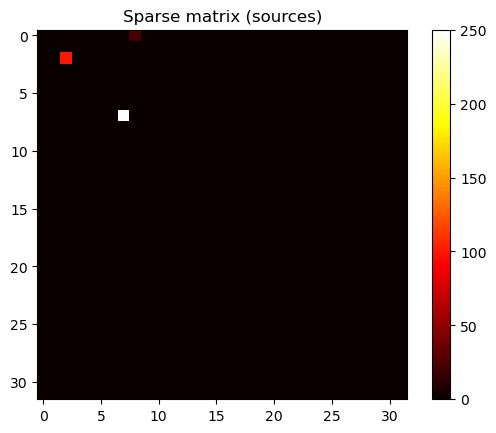

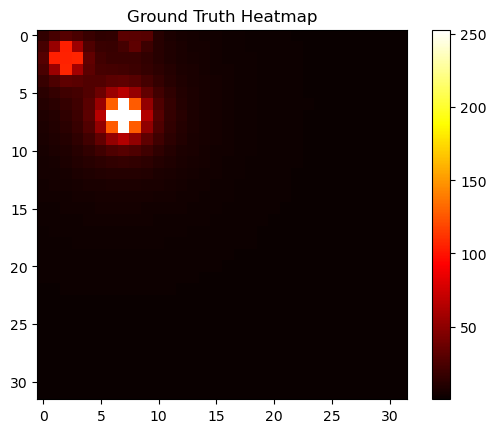

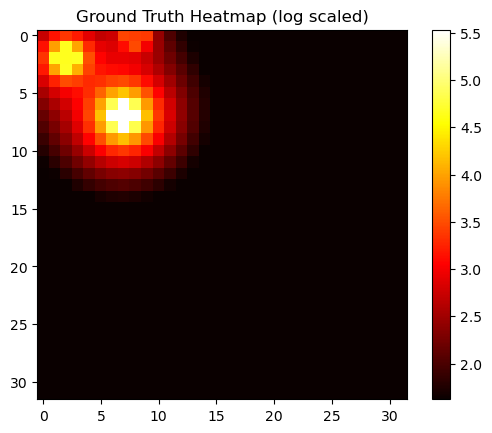

In [8]:
test_sources = np.array([[100, 2, 2], [250, 7, 7], [23, 0, 8]])

test_dim = 32
# Create a ground truth heatmap
ground_truth_heatmap = intensity_matrix(test_dim, test_dim, test_sources)
test_source_sparse = get_sparse_matrix(test_dim, test_dim, test_sources)

print(ground_truth_heatmap.max(), test_source_sparse.max())

# Visualization
plt.imshow(test_source_sparse, cmap='hot', interpolation='nearest')
plt.title("Sparse matrix (sources)")
plt.colorbar()
plt.show()

plt.imshow(ground_truth_heatmap, cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

plt.imshow(log_scale_matrix(ground_truth_heatmap), cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap (log scaled)")
plt.colorbar()
plt.show()

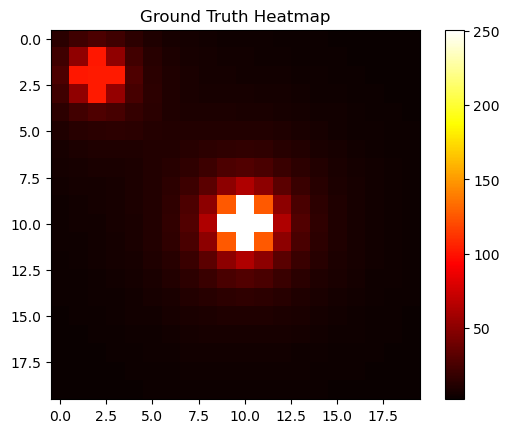

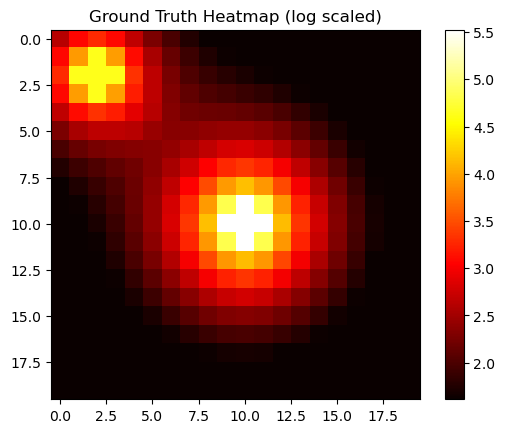

In [7]:
ground_truth_heatmap2 = intensity_matrix(20, 20, [(100, 2, 2), (250, 10, 10), (2, 4, 4)])
plt.imshow(ground_truth_heatmap2, cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

plt.imshow(log_scale_matrix(ground_truth_heatmap2, min_element_pct=0.02), cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap (log scaled)")
plt.colorbar()
plt.show()

Assume we have a fixed number of sensors in a space and we're developing a model based on survey data. Our survey data should be based on fixed snapshots from each sensor (source) at a given point of time, and given those values, we survey a coordinate / X value. We can simulate what an open space heatmap / diffusion looks like with the above code. 

In [9]:
def generate_dataset_sparse(m, n, num_heatmaps=1000, random_pos=False):

    intensity_range = (0,1000)

    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    sparse_matrices = np.zeros((num_heatmaps, m, n))

    for i in range(num_heatmaps):
        
        sources = np.array([[0, 10, 10], [0, 12, 14], [0, 20, 20]])
        
        for k in range(len(sources)):
            
            intensity = random.uniform(intensity_range[0], intensity_range[1])
            sources[k][0] = intensity

            if random_pos is True:
                x = random.randrange(m)
                y = random.randrange(n)

                sources[k][1] = x
                sources[k][2] = y

        heatmap_matrices[i] = intensity_matrix(m, n, sources)
        sparse_matrices[i] = get_sparse_matrix(m, n, sources)

        # print(heatmap_matrices[i].max(), sparse_matrices[i].max())
        
    return sparse_matrices, heatmap_matrices

Most modern machines support multiprocessing / multicore. For example: my core i9 has 24 cores. Running the dataset generation on a single core takes minutes. 

Using multiprocessing on all 24 cores takes ~10 seconds. 

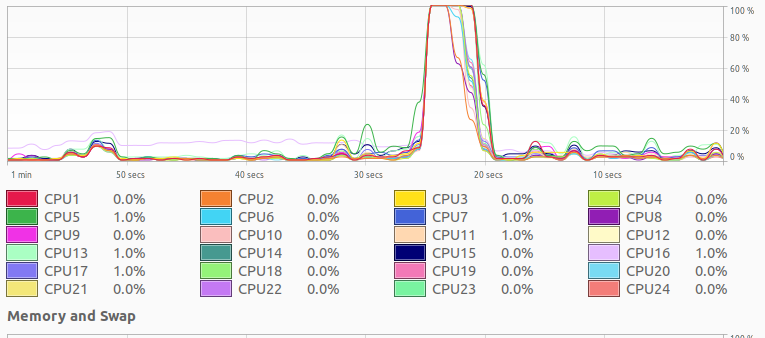

In [10]:
def gen_dset_sparse_wrapper(params_dict):
    Xs, Ys = generate_dataset_sparse(params_dict['m'], params_dict['n'], params_dict['num_heatmaps'], params_dict['random_pos'])
    return (Xs, Ys)

def gen_dataset_multicore(m, n, num_heatmaps, random_pos):
    """ multiprocessing version to accelerate test data creation
        DO NOT call this function unless the number of samples you need is 
        at least 10 times greater than the number of cores you have
    """
    # running this data generator on one CPU core is painful 
    import multiprocessing
    from multiprocessing import Pool
    cpu_count = multiprocessing.cpu_count()
    
    # Print the number of CPU cores available on the system.
    print("Number of cores available:{}".format(cpu_count))
    
    cpu_count = int(cpu_count)

    # we will end up with a few over / under
    n_heatmaps_per_core = int(num_heatmaps / cpu_count)

    params_dict = {"m": m, "n": n, "num_heatmaps": n_heatmaps_per_core, "random_pos": random_pos}
    
    with Pool(cpu_count) as pool:
        #known_words = set(pool.map(hash_word, words))
        all_datasets = list(pool.map(gen_dset_sparse_wrapper, [params_dict for i in range(cpu_count)]))

    Xs = np.zeros((n_heatmaps_per_core * cpu_count, m, n))
    Ys = np.zeros((n_heatmaps_per_core * cpu_count, m, n))
    index = 0
    for dataset in all_datasets:
        Xs[index:index+len(dataset[0])] = dataset[0]
        Ys[index:index+len(dataset[1])] = dataset[1]
        index = index + len(dataset[0])
        
    return Xs, Ys
        

In [117]:
heatmap_w, heatmap_h = 32, 32
num_heatmaps = 10000
random_positions = True


# # if for some reason you can't run it multicore, use the single process:
# Xs, Ys = generate_dataset_sparse(heatmap_w, heatmap_h, num_heatmaps, random_positions)

# # otherwise use all the cores in the machine
# Xs, Ys = gen_dataset_multicore(heatmap_w, heatmap_h, num_heatmaps, random_positions)

# # the global num_heatmaps needs to be mutated if using the multicore version
# num_heatmaps = len(Xs)

10000

In [11]:
# test_index = 12
# print(Ys[test_index].max(), Xs[test_index].max())

# plt.imshow(Ys[test_index], cmap='hot', interpolation='nearest')
# plt.title("Ground Truth Heatmap")
# plt.colorbar()
# plt.show()

# plt.imshow(Xs[test_index], cmap='hot', interpolation='nearest')
# plt.title("X")
# plt.colorbar()
# plt.show()

## Vectorized dataset creation, with scaling
This method runs much faster and doesn't need multithreading. 

Also, there is the option to scale the heatmap to control how the intensity from the sources decays as you move away from them. Essentially this transforms $\text{heatmap}\rightarrow log(\text{heatmap})$. Since the heatmap might have $0$'s, these have to be replaced to avoid taking $log(0)$. This is controlled with the `min_element_pct` parameter. 

Eg if `min_element_pct=0.01` we replace any matrix values less than $max(\text{matrix})\cdot0.01 $ with $max(\text{matrix})\cdot0.01$

Smaller `min_element_pct` makes the "glow" around each source increase.

In [12]:
def generate_dataset_vectorized(m, n, num_sources, num_heatmaps=10, 
                                min_source_intensity = 0, max_source_intensity = 100,
                                log_scale=False, min_element_pct = 0.01):
    """Generates dataset of source matrices (location,intensity of sources) and 
    heatmap matrices (location, intensity due to all sources, obeying inverse-square law)
    PARAMETERS:
        m(int):                 Number of rows in matrix
        n(int):                 Number of columns in matrix
        num_sources(int):       Number of sources to add (random intensity,x,y)
        min_source_intensity(numeric):  Minimum intensity to draw random intensities from
        max_source_intensity(numeric):  Maximum intensity to draw random intensities from
        num_heatmaps(int):      Number of heatmaps to generate
        log_scale(bool):        Whether heatmap intensity should be log scaled
        min_element_pct(float): If log_scale==True, replace intensities below this value with this value (avoids -inf)
    """
    xx,yy = np.meshgrid(np.arange(0, n), np.arange(0, m)) # grid of x,y values
    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    source_matrices = np.zeros((num_heatmaps, m, n))

    for i in range(num_heatmaps):
        source_dist = np.zeros((m, n))
        intensity_dist = np.zeros((m, n))
        
        # make a bunch of random sources
        for _ in range(n_sources):
            intensity,x,y = create_random_source(max_source_intensity, m, n, min_i=min_source_intensity)
            source_dist[y,x] = intensity  
            # add intensity from each source using inverse-square law
            distances = np.sqrt((xx - x)**2 + (yy - y)**2) # distance from ever point in grid to source
            distances = np.where(distances==0, 1, distances) # replace distances less than 1 with 1 to avoid div/0
            intensity_dist += intensity / distances**2                                                               
        
        source_matrices[i] = source_dist
        if log_scale==True:
            heatmap_matrices[i] = log_scale_matrix(intensity_dist, min_element_pct)
        else:
            heatmap_matrices[i] = intensity_dist    
    return source_matrices, heatmap_matrices


def create_random_source(max_i=100, max_y=10, max_x=10, min_i =0):
    """ Creates a tuple that represents a source with random x,y,intensity"""
    intensity = round(min_i + np.random.random()*(max_i-min_i),2)
    x = int(np.random.random()  * max_x)
    y = int(np.random.random() * max_y)
    return intensity, x ,y


def log_scale_matrix(matrix, min_element_pct):
    """Transforms matrix values by taking log of each element. 
    Replaces small values to avoid -inf when taking log
    """
    min_element = matrix.max()*min_element_pct
    return np.log(np.where(matrix<min_element, min_element, matrix)) # replace low intensities to avoid log(intensity)=-inf)


def plot_heatmap(data, title = "", height = 3, cmap="viridis", norm="linear"):  
    """plots a heatmap with colorbar"""
    plt.figure(figsize=(height,height))
    img = plt.imshow(data, cmap=cmap, interpolation='nearest', norm=norm)
    plt.gca().invert_yaxis()
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    return

In [13]:
heatmap_w, heatmap_h = 32, 32
n_sources=3
num_heatmaps = 10000
min_intensity = 10
max_intensity = 100
log_scale=False         # 

Xs, Ys = generate_dataset_vectorized(heatmap_h, heatmap_w, n_sources, num_heatmaps, 
                                     min_intensity, max_intensity,log_scale)
Xs.shape

(10000, 32, 32)

6144


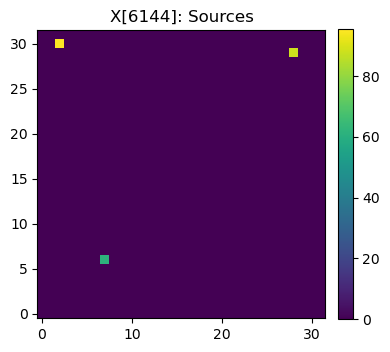

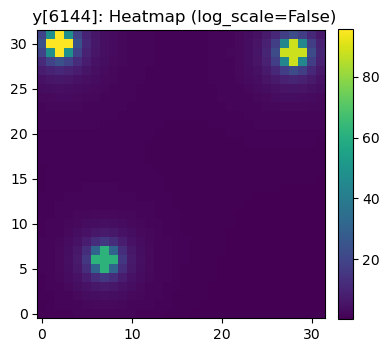

In [14]:
# Look at a sample
idx = np.random.randint(Xs.shape[0])
print(idx)
plot_heatmap(Xs[idx], height = 4, title=f"X[{idx}]: Sources")
plot_heatmap(Ys[idx], height = 4, title=f" y[{idx}]: Heatmap (log_scale={log_scale})")

In [15]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU

def build_model_leaky(n_inputs, hidden_layers=[10, 10, 10], n_out=1, dropout=0., alpha=0.3):
    """
    builds a neural network using the depth and layer sizes provided by hidden_layers arg
    choose an activation function from the supported functions in activations
    
    when Keras initializes the weights and biases, they're set to random values, this can 
    cause each instance of the model to perform radically differently 
    
    As such, when we compare the results for different epochs, normalization, etc. the 
    weights and biases should be set using the same seed and initializer
    """
    initializer = GlorotUniform(seed=808)
    
    model = Sequential()
    for i, layer in enumerate(hidden_layers):
        if i == 0:
            # define the input shape based on n_inputs
            model.add(Dense(hidden_layers[i], input_shape=(n_inputs,), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
        else:
            model.add(Dropout(dropout))
            model.add(BatchNormalization())
            # base the input shape on the previous layer
            model.add(Dense(hidden_layers[i], input_shape=(hidden_layers[i-1],), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
    
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # add our output layer
    model.add(Dense(n_out, input_shape=(hidden_layers[len(hidden_layers)-1],), kernel_initializer=initializer))
    
    # build the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [16]:
# test the model builder function and use model.summary to verify the shapes we expect from this test
test_model = build_model_leaky(heatmap_w*heatmap_h, [1024, 1024, 2048], n_out=heatmap_w*heatmap_h)

# show the model summary
test_model.summary()

# also, verify the input / output shapes since model.summary only shows outputs
for i, layer in enumerate(test_model.layers):
    print("Layer {0} input shape: {1} output shape:{2}".format(i+1, layer.input_shape[1], layer.output_shape[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                        

In [17]:
Xs_reshaped = Xs.reshape((num_heatmaps, heatmap_w*heatmap_h))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))

X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [19]:
n_epochs = 100
hidden_layers = [8192, 8192]
batch_size = 300
alpha = 0.2

best_model_name = 'best_linear_dispersion_model.h5'

# saving the best model weights
checkpoint = ModelCheckpoint(best_model_name, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
# note that dropout is essentially disabled by default
model = build_model_leaky(heatmap_w*heatmap_h, hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    # callbacks=[checkpoint],
                    verbose=1)

Epoch 1/100
27/27 [==============================] - 18s 649ms/step - loss: 39.0861 - mean_squared_error: 39.0861 - val_loss: 40.7110 - val_mean_squared_error: 40.7110
Epoch 2/100
27/27 [==============================] - 17s 617ms/step - loss: 9.7740 - mean_squared_error: 9.7740 - val_loss: 51.1040 - val_mean_squared_error: 51.1040
Epoch 3/100
27/27 [==============================] - 15s 564ms/step - loss: 12.6755 - mean_squared_error: 12.6755 - val_loss: 56.4187 - val_mean_squared_error: 56.4187
Epoch 4/100
27/27 [==============================] - 18s 654ms/step - loss: 6.1607 - mean_squared_error: 6.1607 - val_loss: 24.9610 - val_mean_squared_error: 24.9610
Epoch 5/100
27/27 [==============================] - 16s 590ms/step - loss: 3.3888 - mean_squared_error: 3.3888 - val_loss: 14.3583 - val_mean_squared_error: 14.3583
Epoch 6/100
27/27 [==============================] - 17s 610ms/step - loss: 2.2708 - mean_squared_error: 2.2708 - val_loss: 8.6718 - val_mean_squared_error: 8.6718
Ep

In [22]:
preds = model.predict(X_test)

63/63 [==============================] - 2s 27ms/step


In [23]:
def plot_compare_heatmaps(input, original, predicted):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Plot original heatmap
    im0 = axes[0].imshow(input, cmap='plasma', origin='lower')
    axes[0].set_title("Sparse input")
    fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)

    # Plot original heatmap
    im1 = axes[1].imshow(original, cmap='plasma', origin='lower')
    axes[1].set_title("Simulated Intensity")
    fig.colorbar(im1, ax=axes[1],fraction=0.046, pad=0.04)

    # Plot predicted heatmap
    im2 = axes[2].imshow(predicted, cmap='plasma', origin='lower')
    axes[2].set_title("Predicted Intensity")
    fig.colorbar(im2, ax=axes[2],fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

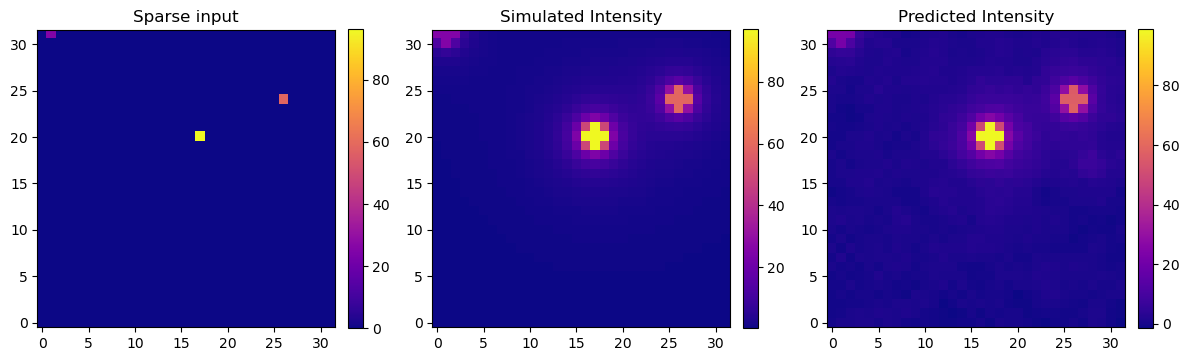

In [24]:
plot_compare_heatmaps(X_test[10].reshape((heatmap_w, heatmap_h)), y_test[10].reshape((heatmap_w, heatmap_h)), preds[10].reshape((heatmap_w,heatmap_h)))

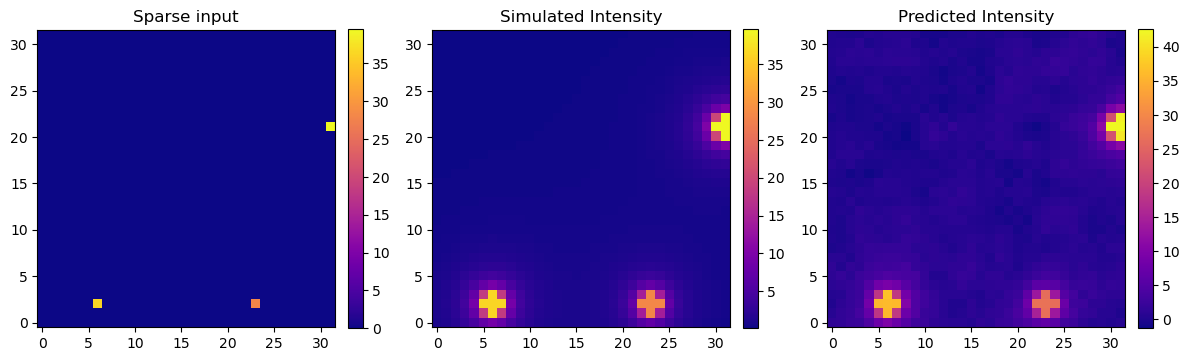

In [25]:
plot_compare_heatmaps(X_test[20].reshape((heatmap_w, heatmap_h)), y_test[20].reshape((heatmap_w, heatmap_h)), preds[20].reshape((heatmap_w,heatmap_h)))

## Can we input arbitrary sources / intensites in our sparse matrix. 

The previous model learned to approximate the 2D heatmap algorithm from a fixed number of sparse inputs but can we input arbitrary number / intensity of sources into this model and have it predict the heatmap?

In [26]:
test_sources = np.array([[600, 2, 5], [800, 10, 20], [100, 15, 15], [600, 22, 22], [600, 2, 20]])
test_sources_sparse = get_sparse_matrix(heatmap_w, heatmap_h, test_sources)
test_sources_flat = test_sources_sparse.reshape((heatmap_w * heatmap_h))

test_Xs = np.zeros((1, heatmap_h * heatmap_w))
test_Xs [0] = test_sources_flat

test_preds = model.predict(test_Xs)

1/1 [==============================] - 0s 82ms/step


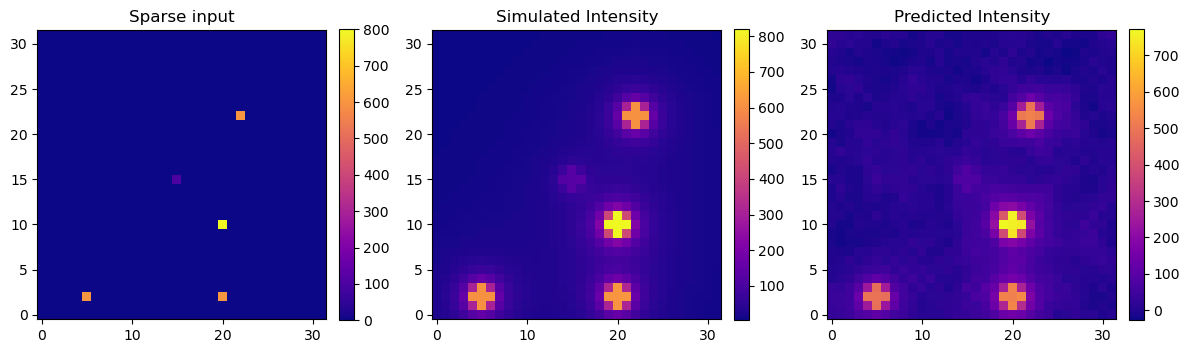

In [27]:
test_Yhat = test_preds[0].reshape((heatmap_w, heatmap_h))

plot_compare_heatmaps(test_sources_sparse, intensity_matrix(heatmap_w, heatmap_h, test_sources), test_Yhat)

This is great, it does work, but again, the low intensity sources are noisy and the background is noisy. It's likley we need to standardize the input and/or adjust the architecture. With that said, this form of network is not optimal. We'll a) want to see if we can capture the spatial positions as features and b) create CNN and/or other generative forms. 

# Repeat with log-scaled inputs
Above the model predicted inverse-square distributions. Can it predict other ones?
Test this by taking the inverse-square distribution and log-scaling it to make the heatmap values decay slower as the distance from the sources increase. This makes the sources have more of a "halo".

In [30]:
heatmap_w, heatmap_h = 32, 32
n_sources=3
num_heatmaps = 10000
min_intensity = 10
max_intensity = 100
log_scale=True 
min_element_pct = 0.03   # controls size of "glow" around source when log_scale=True

Xs, Ys = generate_dataset_vectorized(heatmap_h, heatmap_w, n_sources, num_heatmaps, 
                                     min_intensity, max_intensity,log_scale)
Xs.shape

(10000, 32, 32)

3781


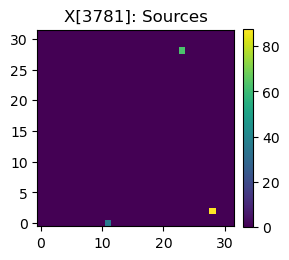

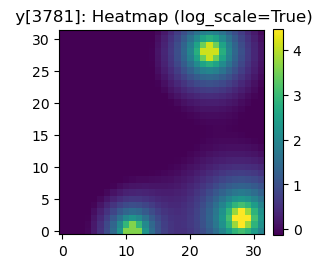

In [41]:
# Look at a sample
idx = np.random.randint(Xs.shape[0])
print(idx)
plot_heatmap(Xs[idx], height = 3, title=f"X[{idx}]: Sources")
plot_heatmap(Ys[idx], height = 3, title=f" y[{idx}]: Heatmap (log_scale={log_scale})")

In [32]:
Xs_reshaped = Xs.reshape((num_heatmaps, heatmap_w*heatmap_h))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))

X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 1024) (8000, 1024)
(2000, 1024) (2000, 1024)


In [33]:
n_epochs = 100
hidden_layers = [8192, 8192]
batch_size = 300
alpha = 0.2

best_model_name = 'best_linear_dispersion_model_scaled.h5'

# saving the best model weights
checkpoint = ModelCheckpoint(best_model_name, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
# note that dropout is essentially disabled by default
scaled_model = build_model_leaky(heatmap_w*heatmap_h, hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = scaled_model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    # callbacks=[checkpoint],
                    verbose=1)

Epoch 1/100
27/27 [==============================] - 14s 474ms/step - loss: 1.4002 - mean_squared_error: 1.4002 - val_loss: 2.4778 - val_mean_squared_error: 2.4778
Epoch 2/100
27/27 [==============================] - 13s 496ms/step - loss: 0.3592 - mean_squared_error: 0.3592 - val_loss: 1.4807 - val_mean_squared_error: 1.4807
Epoch 3/100
27/27 [==============================] - 13s 473ms/step - loss: 0.1946 - mean_squared_error: 0.1946 - val_loss: 0.7915 - val_mean_squared_error: 0.7915
Epoch 4/100
27/27 [==============================] - 14s 505ms/step - loss: 0.1423 - mean_squared_error: 0.1423 - val_loss: 0.3973 - val_mean_squared_error: 0.3973
Epoch 5/100
27/27 [==============================] - 14s 527ms/step - loss: 0.1116 - mean_squared_error: 0.1116 - val_loss: 0.2960 - val_mean_squared_error: 0.2960
Epoch 6/100
27/27 [==============================] - 15s 560ms/step - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.2282 - val_mean_squared_error: 0.2282
Epoch 7/100
27/2

In [34]:
preds = scaled_model.predict(X_test)

63/63 [==============================] - 2s 25ms/step


Predictions using log scaled heatmap


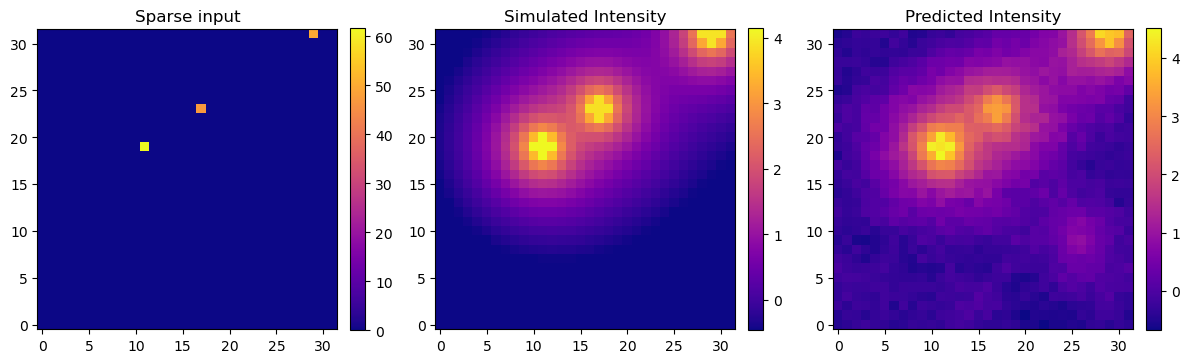

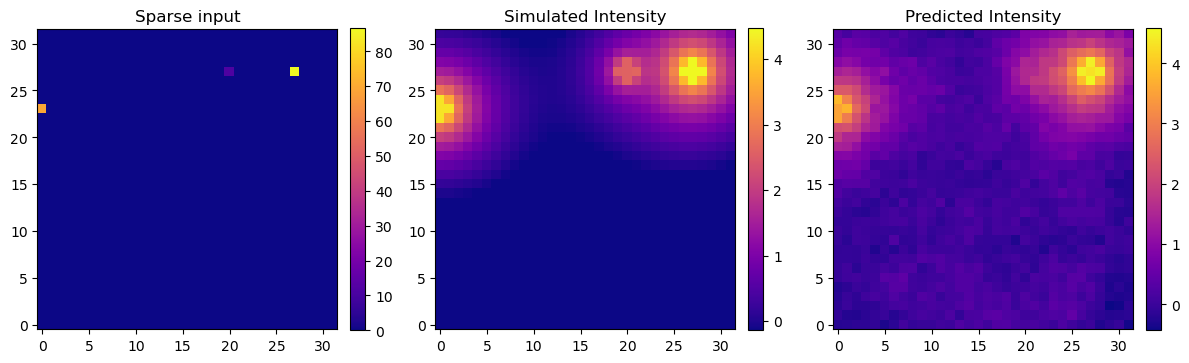

In [43]:
idx=10
print("Predictions using log scaled heatmap")
plot_compare_heatmaps(X_test[idx].reshape((heatmap_w, heatmap_h)), y_test[idx].reshape((heatmap_w, heatmap_h)), preds[idx].reshape((heatmap_w,heatmap_h)))

idx=20
plot_compare_heatmaps(X_test[idx].reshape((heatmap_w, heatmap_h)), y_test[idx].reshape((heatmap_w, heatmap_h)), preds[idx].reshape((heatmap_w,heatmap_h)))

###  Using the same fixed inputs as before (but now log-scaled)

In [39]:
test_sources = np.array([[600, 2, 5], [800, 10, 20], [100, 15, 15], [600, 22, 22], [600, 2, 20]])
test_sources_sparse = get_sparse_matrix(heatmap_w, heatmap_h, test_sources)
test_sources_flat = test_sources_sparse.reshape((heatmap_w * heatmap_h))



test_Xs = np.zeros((1, heatmap_h * heatmap_w))
test_Xs [0] = test_sources_flat

test_preds = scaled_model.predict(test_Xs)

1/1 [==============================] - 0s 88ms/step


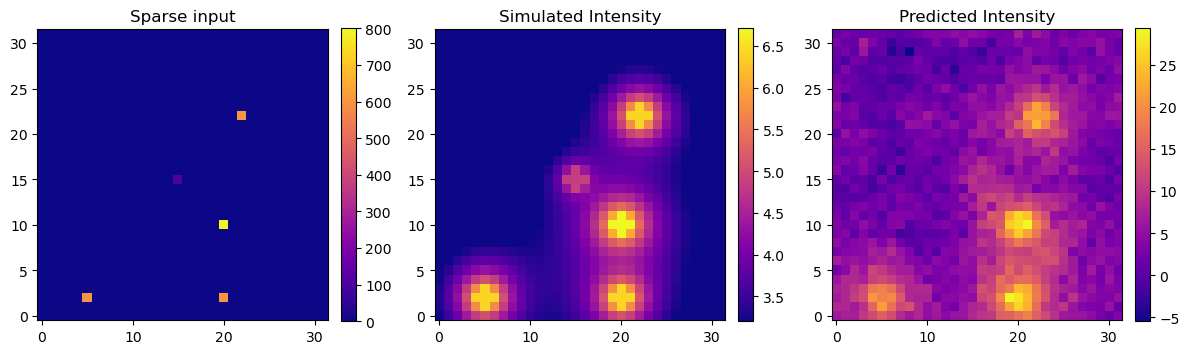

In [54]:
test_Yhat = test_preds[0].reshape((heatmap_w, heatmap_h))

plot_compare_heatmaps(test_sources_sparse, 
                      log_scale_matrix(intensity_matrix(heatmap_w, heatmap_h, test_sources), min_element_pct), 
                      test_Yhat)

### Notes
Using log-scaled heatmaps that are "spread out" compared to inverse-square heatmaps results in noisier predictions that have trouble with less intense sources.

# "Dense" Version

Instead of a sparse matrix as input, the network may learn better where the input matrix contains the source x,y,intensity values as features. However, coming up with an embedding solution for *N* number of dense inputs (*N* sources) will be an exercise for the near future. For now, we'll focus on building a dense input with fixed number of sources and determine if using the x,y location as a feature helps learn the spatial relationships better. 

In [44]:
def generate_dataset_dense(m, n, num_heatmaps=1000, n_sources=4):

    sources = np.zeros((n_sources, 3))

    intensity_range = (0,10)

    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    dense_matrices = np.zeros((num_heatmaps, sources.shape[0] * sources.shape[1]))

    # build num_heatmaps
    for i in range(num_heatmaps):
        # randomize the intensities and / or source positions
        for k in range(n_sources):
            
            intensity = random.uniform(intensity_range[0], intensity_range[1])
            sources[k][0] = intensity
            
            # randomize the source position as well
            source_x = random.uniform(0, m)
            source_y = random.uniform(0, n)
            
            sources[k][1] = int(source_x)
            sources[k][2] = int(source_y)

        heatmap_matrices[i] = intensity_matrix(m, n, sources)
        dense_matrices[i] = sources.flatten()
        
    return dense_matrices, heatmap_matrices

In [45]:
n_heatmaps_dense = 1000

Xs_dense, Ys_dense = generate_dataset_dense(heatmap_w, heatmap_h, num_heatmaps=n_heatmaps_dense)

In [46]:
print(Xs_dense.shape, Ys_dense.shape)

(1000, 12) (1000, 32, 32)


In [47]:
print(Xs_dense[0])

[ 0.95764457 26.          4.          6.4723126  11.          2.
  6.43679162 26.         17.          7.40397019 26.          5.        ]


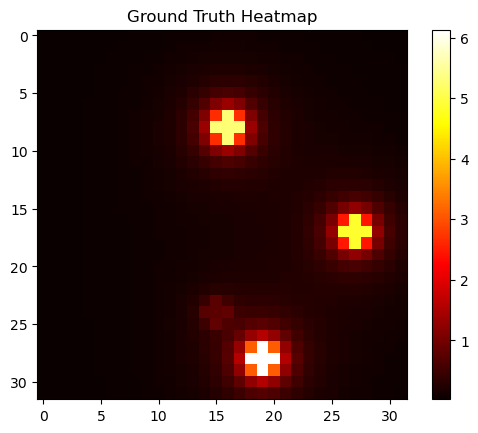

In [48]:
plt.imshow(Ys_dense[100], cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

In [49]:
ys_reshaped_dense = Ys_dense.reshape((n_heatmaps_dense, heatmap_w*heatmap_h))

In [50]:
X_train_dense, X_test_dense, y_train_dense, y_test_dense = train_test_split(Xs_dense, ys_reshaped_dense, test_size=0.2, random_state=42)

print(X_train_dense.shape, y_train_dense.shape)
print(X_test_dense.shape, y_test_dense.shape)

(800, 12) (800, 1024)
(200, 12) (200, 1024)


In [51]:
n_epochs = 100
hidden_layers = [1024, 1024, 1024, 1024]
batch_size = 32
alpha = 0.2

best_model_name = 'best_linear_dispersion_model_dense.h5'

# saving the best model weights
checkpoint_dense = ModelCheckpoint(best_model_name, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
# note that dropout is essentially disabled by default
model_dense = build_model_leaky(X_train_dense.shape[1], hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = model_dense.fit(X_train_dense, y_train_dense, 
                    validation_data=(X_test_dense, y_test_dense), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpoint_dense],
                    verbose=1)

Epoch 1/100
21/25 [========================>.....] - ETA: 0s - loss: 1.2668 - mean_squared_error: 1.2668
Epoch 1: val_loss improved from inf to 4.93478, saving model to best_linear_dispersion_model_dense.h5
25/25 [==============================] - 1s 17ms/step - loss: 1.2386 - mean_squared_error: 1.2386 - val_loss: 4.9348 - val_mean_squared_error: 4.9348
Epoch 2/100
 1/25 [>.............................] - ETA: 0s - loss: 1.0014 - mean_squared_error: 1.0014

/Users/trevorkinsey/opt/miniconda3/envs/ml2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/25 [========================>.....] - ETA: 0s - loss: 0.9673 - mean_squared_error: 0.9673
Epoch 2: val_loss improved from 4.93478 to 3.38565, saving model to best_linear_dispersion_model_dense.h5
25/25 [==============================] - 0s 13ms/step - loss: 0.9630 - mean_squared_error: 0.9630 - val_loss: 3.3857 - val_mean_squared_error: 3.3857
Epoch 3/100
22/25 [=========================>....] - ETA: 0s - loss: 0.8829 - mean_squared_error: 0.8829
Epoch 3: val_loss improved from 3.38565 to 2.08082, saving model to best_linear_dispersion_model_dense.h5
25/25 [==============================] - 0s 14ms/step - loss: 0.8727 - mean_squared_error: 0.8727 - val_loss: 2.0808 - val_mean_squared_error: 2.0808
Epoch 4/100
22/25 [=========================>....] - ETA: 0s - loss: 0.8270 - mean_squared_error: 0.8270
Epoch 4: val_loss improved from 2.08082 to 1.44576, saving model to best_linear_dispersion_model_dense.h5
25/25 [==============================] - 0s 12ms/step - loss: 0.8281 - mean_squ

In [52]:
preds_dense = model_dense.predict(X_test_dense)

7/7 [==============================] - 0s 3ms/step


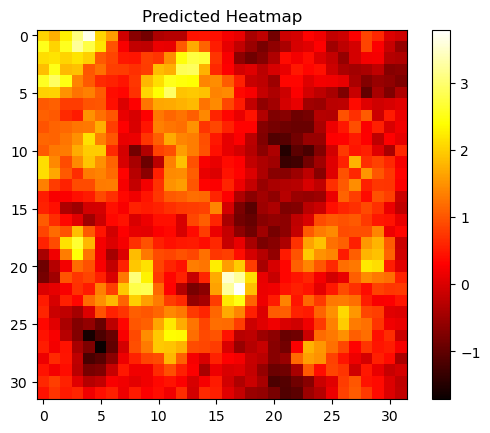

In [53]:
plt.imshow(preds_dense[20].reshape(heatmap_w, heatmap_h), cmap='hot', interpolation='nearest')
plt.title("Predicted Heatmap")
plt.colorbar()
plt.show()